# Data reduction 

Using AstroObjectAnalyzer,
Modified from [https://github.com/Project-Dinos/dinos-i/blob/main/1_HST_lens_processing/3_Pre-Processor.ipynb]

In [1]:
import glob
import os
import time
import shutil
import h5py
from pathlib import Path
import copy

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Util.util as util

from astroObjectAnalyser.astro_object_superclass import StrongLensSystem
from astroObjectAnalyser.DataAnalysis.analysis import Analysis

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import ImageNormalize, LogStretch
from astropy.table import Table

import matplotlib.colors as colors
import pyregion
from starred.plots import plot_function as pltf

In [2]:
def InitiateSystem(name, filter, ra, dec, ra_cutout_cent = None, dec_cutout_cent = None):
    
    reduced_data_folder = '/home/xhuang/doubles_hst/reduced_data'
    path2reduced_data = os.path.join(reduced_data_folder, filter, name)

    # initiate a strong lens class
    system = StrongLensSystem(name)

    if filter in ['F814W', 'F475X']:
        drizzled_img_type = 'drc'
    if filter == 'F160W':
        drizzled_img_type = 'drz'

    # path to science and weight images
    img_file = name + '_' + drizzled_img_type + '_sci.fits'
    wht_file = name + '_' + drizzled_img_type + '_wht.fits'
    path2img_data = os.path.join(path2reduced_data, img_file)
    path2wht_data = os.path.join(path2reduced_data, wht_file)

    # add image data instance
    if ra_cutout_cent == None:
        ra_cutout_cent = ra
    if dec_cutout_cent == None:
        dec_cutout_cent = dec
    system.add_image_data_init(filter, path2img_data, local_wht_filename=path2wht_data, cutout_scale=100, data_type='HST_new', ra = dec, dec = dec, ra_cutout_cent=ra_cutout_cent, dec_cutout_cent=dec_cutout_cent)

    return system

def PreProcess(name, filter, ra, dec, ra_cutout_cent = None, dec_cutout_cent = None, display_img = True, remove_sex_cat = False):

    system = InitiateSystem(name, filter, ra, dec, ra_cutout_cent, dec_cutout_cent)

    cutout_data_folder = os.path.abspath('./reduced_data/cutout_data')
    path2cutout_data = os.path.join(cutout_data_folder, filter, name)

    # get cutout image
    img_cutout = system.get_cutout_image(filter, 100, force=True)

    if display_img:
        # display cutout image
        norm = ImageNormalize(np.arccosh(img_cutout), vmin=-0.2, vmax=25, stretch=LogStretch())
        plt.imshow(img_cutout, norm=norm, cmap = 'viridis', origin='lower')
        plt.title(name, size = 22)
        # plt.savefig('./exmaple_cutout.png', dpi=300, bbox_inches='tight')

    # background subtraction
    mean_bkd, sigma_bkd = system.get_background(filter)
    # subtract background noise mean from cutout data
    img_cutout_reduced = img_cutout - mean_bkd

    # get weight map cutout
    wht_cutout = system.get_exposure_map(filter)
    # untis in pixels are originally electrons/s
    # we estimate the Poisson noise term in respect to a smaller IID count rate
    # wht_cutout /= 1.5 # 1.5 is equivalent to the CCD_gain parameter
    # for numerics, replace 0 with small number
    wht_cutout[wht_cutout <= 0] = 10**(-10)  # just making sure that there are non-negative exposure times

    # align cooordinate to cutout image
    ra_at_xy_0, dec_at_xy_0 = system.coord_at_pixel_0(filter)
    Matrix_inv = system.get_transform_matrix_pix2angle(filter)

    # make cutout directory
    if not os.path.isdir(path2cutout_data):
        os.makedirs(path2cutout_data)
    else:
        pass

    # save cutout data configurations in hdf5 format
    h5filename = 'cutout_{}_{}.hdf5' .format(name, filter)
    path2h5file = os.path.join(path2cutout_data, h5filename)
    with h5py.File(path2h5file, 'w') as f:
        f.create_dataset('sci_cutout', data=img_cutout_reduced) 
        f.create_dataset('background_rms', data=sigma_bkd)
        f.create_dataset('background_mean', data=mean_bkd)
        f.create_dataset('wht_cutout', data=wht_cutout)
        f.create_dataset('ra_at_xy_0', data=ra_at_xy_0)
        f.create_dataset('dec_at_xy_0', data=dec_at_xy_0)
        f.create_dataset('transform_pix2angle', data=Matrix_inv)
    
    # save the sextractor catalog under the cutout folder
    path2sexcat = os.path.join(path2cutout_data, 'pysex_{}_{}.cat' .format(name, filter))
    shutil.copyfile('./.pysex.cat', path2sexcat)

    if remove_sex_cat:
        file_list = glob.glob('./.pysex*')
        for file in file_list:
            os.remove(file)

def Path2PreprocessFiles(name, filter):
    """print path string of pre-processing files

    Args:
        name (_type_): _description_
        filter (_type_): _description_
    """
    cutout_data_folder = '/home/xhuang/doubles_hst/reduced_data/cutout_data'
    path2cutout_data = os.path.join(cutout_data_folder, filter, name)

    h5filename = 'cutout_{}_{}.hdf5' .format(name, filter)
    path2h5file = os.path.join(path2cutout_data, h5filename)
    print('path to h5 file: {}' .format(path2h5file))

    path2sexcat = os.path.join(path2cutout_data, 'pysex_{}_{}.cat' .format(name, filter))
    print('path to sextractor catalog: {}' .format(path2sexcat))

    return path2h5file, path2sexcat

121.5986666667 20.10873888889
the center of the image is at pixel coordinates 2339.534471, 2072.026856.
ccd gain = 1.5
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: /home/xhuang/sextractor/src/sex /home/xhuang/doubles_hst/reduced_data/F814W/J0806+2006/J0806+2006_drc_sci.fits -c .pysex.sex -GAIN 2142.0 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw


/tmp/ipykernel_654277/1920976563.py:41: RuntimeWarning: invalid value encountered in arccosh
  norm = ImageNormalize(np.arccosh(img_cutout), vmin=-0.2, vmax=25, stretch=LogStretch())
> 
----- SExtractor 2.28.0 started on 2024-11-07 at 10:22:32 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for J0806+2006_drc_sci.fits
----- Measuring from: J0806+2006_drc_sci.fits [0/2]
      "Unnamed" / no ext. header / 5793x5869 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting

the center of the image is at pixel coordinates 2339.534471, 2072.026856.
separate exposure map loaded
path to h5 file: /home/xhuang/doubles_hst/reduced_data/cutout_data/F814W/J0806+2006/cutout_J0806+2006_F814W.hdf5
path to sextractor catalog: /home/xhuang/doubles_hst/reduced_data/cutout_data/F814W/J0806+2006/pysex_J0806+2006_F814W.cat


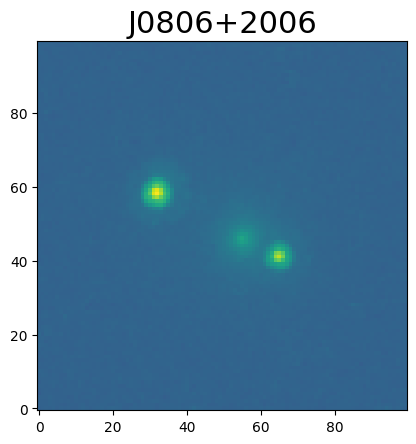

In [3]:
object_name = 'J0806+2006'
filter = 'F814W'

rerun_preprocess = True

if filter in ['F814W', 'F475X']:
    drizzled_img_type = 'drc'
if filter == 'F160W':
    drizzled_img_type = 'drz'

# get ra and dec from image
with fits.open('/home/xhuang/doubles_hst/reduced_data/{}/{}/{}_{}_sci.fits' .format(filter, object_name, object_name, drizzled_img_type)) as hdu:
    sci_header = hdu[0].header
    ra_targ = sci_header['ra_targ']
    dec_targ = sci_header['dec_targ']
    print(ra_targ, dec_targ)

if rerun_preprocess:
    PreProcess(object_name, filter, ra_targ, dec_targ, ra_targ - 0.4/3600, dec_targ + 0.2/3600, remove_sex_cat=True)

path2h5file, path2sexcat = Path2PreprocessFiles(object_name, filter)

## PSF reconstruction
### Select stars for PSF extraction

In [4]:
cat = fits.open(path2sexcat)[2]
cat_table = Table(cat.data)
print(cat_table.colnames)
pix_targ = [[2330, 2067]] # quasar and host position
# pix_center = np.mean([pix_targ[0], pix_targ[1]], axis=1) # I take the center of the doubles to be the center of the system
offset = 50
mask_quasar = (abs(cat_table['X_IMAGE'] - pix_targ[0][0]) < offset) & (abs(cat_table['Y_IMAGE'] - pix_targ[0][1]) < offset)
cat_table[mask_quasar]

['NUMBER', 'FLAGS', 'X_IMAGE', 'Y_IMAGE', 'FLUX_BEST', 'FLUXERR_BEST', 'MAG_BEST', 'MAGERR_BEST', 'FLUX_RADIUS', 'CLASS_STAR', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'ELLIPTICITY', 'X_WORLD', 'Y_WORLD']


NUMBER,FLAGS,X_IMAGE,Y_IMAGE,FLUX_BEST,FLUXERR_BEST,MAG_BEST,MAGERR_BEST,FLUX_RADIUS,CLASS_STAR,A_IMAGE,B_IMAGE,THETA_IMAGE,ELLIPTICITY,X_WORLD,Y_WORLD
int32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
1246,3,2354.8503,2064.134,114.070465,0.30395144,26.485666,0.0028937487,1.8628385,0.99127924,4.03083,3.0036755,82.13368,0.25482458,121.59838615962359,20.10869564016445
1292,3,2345.3196,2068.6533,81.79594,0.34861118,26.84677,0.0046284907,7.1711807,0.1460208,9.275714,4.6893716,60.17272,0.49444628,121.59849893481412,20.10874585174947
1318,2,2322.0908,2081.23,216.48883,0.36359757,25.79001,0.00182396,1.670671,0.9805647,4.292934,3.636026,57.64816,0.15302074,121.59877379162938,20.108885581807133
1421,0,2367.092,2038.2058,0.49352083,0.1086102,32.395336,0.23899837,2.2267296,0.46385464,1.4978721,0.9242474,17.527884,0.38295972,121.59824129929947,20.108407554956145
1482,0,2375.5483,2050.257,0.7869825,0.115667194,31.888687,0.15961546,2.936583,0.44335333,1.1624006,1.0272536,-33.55094,0.116265416,121.59814124889367,20.10854146178723
1502,3,2376.3025,2068.75,3.4129727,0.1611117,30.295767,0.05126537,3.7105155,0.5046186,2.280256,1.2142055,63.941055,0.4675135,121.59813233246298,20.108746938025188
1604,0,2358.5774,2112.1008,0.30994666,0.098734096,32.900383,0.34594736,1.4167473,0.4888278,1.3506515,0.73397493,-76.661896,0.45657712,121.59834208259888,20.109228607092994


{'MagMaxThresh': 25.2819766998291, 'MagMinThresh': 21.54568099975586, 'SizeMinThresh': 1.5072476863861084, 'SizeMaxThresh': 5.507247686386108, 'EllipticityThresh': 0.1, 'ClassStarMax': 1.0, 'ClassStarMin': 0.5}
Blended PSF stars excluded.
Check saturation result: no saturation of PSF stars. 
Quasar excluded.
6 number of stars


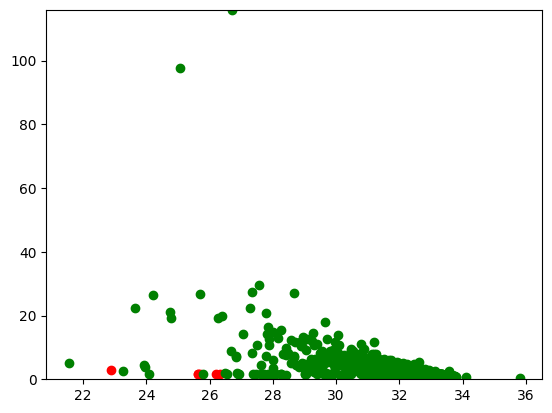

In [5]:
# identify quasar
cat_quasar_num = [1246, 1292, 1318] # from the sextractor catalog
# cat_quasar_num = []

# magnitude-size plot
mag = np.array(cat.data['MAG_BEST'],dtype=float)
mag[mag > 50] = np.mean(mag)
size = np.array(cat.data['FLUX_RADIUS'],dtype=float)

analysis = Analysis()

# select stars
kwargs_cuts = analysis.estimate_star_thresholds(cat)
print(kwargs_cuts)
# kwargs_cuts['ClassStarMin'] = 0.1
kwargs_cuts['EllipticityThresh'] = 0.3
kwargs_cuts['MagMinThresh'] = 22
kwargs_cuts['MagMaxThresh'] = 26.5
kwargs_cuts['SizeMinThresh'] = 0.5
kwargs_cuts['SizeMaxThresh'] = 7
mask = analysis.find_objects(cat, kwargs_cuts)

def exclude_blended(mask, cat):
    """exclude blended psf stars

    Args:
        mask (_type_): mask return by astroobject analyzer
        cat (_type_): sextractor catalog

    Returns:
        _type_: updated mask
    """
    flags_mask = cat.data[mask]['FLAGS']
    mask_mask = mask[mask]
    mask_mask = np.where(flags_mask == 3, False, True)
    mask[mask == True] = mask_mask
    print('Blended PSF stars excluded.')
    return mask

def exclude_saturation(mask, cat):
    """exclude saturated psf stars

    Args:
        mask (_type_): _description_
        cat (_type_): _description_

    Returns:
        _type_: _description_
    """
    flags_mask = cat.data[mask]['FLAGS']
    mask_mask = mask[mask]
    flags_all = np.zeros_like(flags_mask)
    for i, flag in enumerate(flags_mask):
        flag_saturation = np.binary_repr(int(flag), 8)[-3]
        if flag_saturation == 1:
            print('Warning: the {i}-th psf star has at least 1 pixel saturated!' .format(i))
            mask_mask[i] = False
    if np.sum(flags_all) == 0:
        print('Check saturation result: no saturation of PSF stars. ')
    mask[mask == True] = mask_mask
    return mask

def exclude_quasar(mask, cat, quasar_num):
    """exclude quasars in PSF stars

    Args:
        mask (_type_): _description_
        cat (_type_): _description_
        quasar_num (_type_): the "NUMBER" id of the quasar in sextractor catalog

    Returns:
        _type_: _description_
    """
    obj_num = cat.data[mask]['NUMBER']
    mask_mask = mask[mask]
    for i, num in enumerate(obj_num):
        if num in quasar_num:
            mask_mask[i] = False
    mask[mask == True] = mask_mask
    print('Quasar excluded.')
    return mask


mask = exclude_blended(mask, cat) # exclude blended objects (only here)
mask = exclude_saturation(mask, cat)
mask = exclude_quasar(mask, cat, cat_quasar_num)


print(np.sum(mask), 'number of stars')
plt.plot(mag[mask > 0], size[mask > 0], 'or')
plt.plot(mag[mask == 0], size[mask == 0], 'og')
plt.ylim([0, np.max(size)])
plt.show()

# TODO: check proximity to the quasar system

# exclude psf stars close to the edge of one chip
mask_edge = copy.deepcopy(mask[mask])
for i in [0, 4]:
    mask_edge[i] = False
mask[mask == True] = mask_edge


In [6]:
cat_table[mask] 

NUMBER,FLAGS,X_IMAGE,Y_IMAGE,FLUX_BEST,FLUXERR_BEST,MAG_BEST,MAGERR_BEST,FLUX_RADIUS,CLASS_STAR,A_IMAGE,B_IMAGE,THETA_IMAGE,ELLIPTICITY,X_WORLD,Y_WORLD
int32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
529,0,3916.1106,1438.7603,131.48538,0.26692,26.331406,0.0022046186,1.5076302,0.9729233,2.2450905,2.2021773,-89.220184,0.019114256,121.5799132591282,20.10174674964038
667,0,2233.234,1575.8623,249.7159,0.3599892,25.634983,0.0015655722,1.5639213,0.98672146,2.6145072,2.5083413,85.67484,0.04060644,121.599824900318,20.103270343160858
1211,0,1954.999,1955.1016,149.7287,0.28497186,26.190336,0.0020669347,1.5572814,0.9810023,2.4095309,2.364466,4.2998443,0.018702805,121.60311727075396,20.107483935251555
2997,0,1849.1744,2815.7375,250.29155,0.36021894,25.632484,0.0015629684,1.5544698,0.9957161,2.6248298,2.5129817,68.99866,0.0426116,121.60437017500588,20.117046473972675


### make PSF star cutouts

separate exposure map loaded


/tmp/ipykernel_654277/1823426367.py:29: RuntimeWarning: invalid value encountered in arccosh
  norm = ImageNormalize(np.arccosh(star_imgs[i]), vmin = -0.2, vmax = 25, stretch=LogStretch())


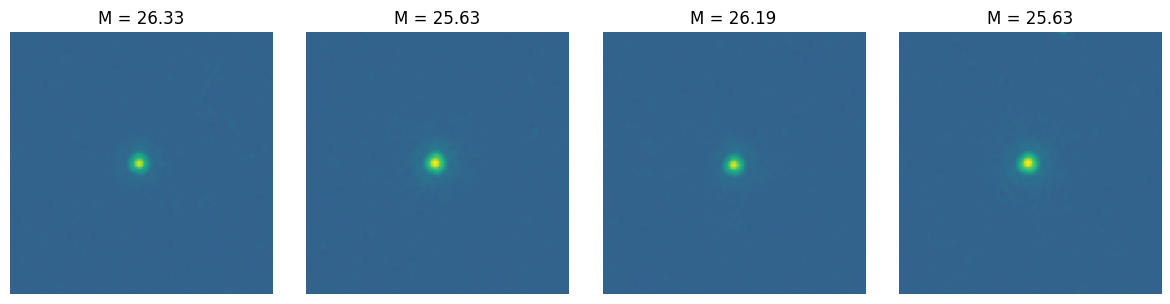

In [7]:
system = InitiateSystem(object_name, filter, ra_targ, dec_targ)

with h5py.File(path2h5file, 'r') as f:
    mean_bkd = f['background_mean'][()]
    sigma_bkd = f['background_rms'][()]

img_full = system.get_full_image(filter) # get the full image
star_imgs= analysis.get_objects_image(img_full - mean_bkd, cat, mask, 50) # get star cutouts, background subtracted

wht_full = system.get_full_exposure(filter) # get the full exposure map
wht_full[wht_full <= 0] = 10**(-10)
star_whts = analysis.get_objects_image(wht_full, cat, mask, 50) # get exposure map cutouts for stars

# convert the cutouts into units of e-
# exp_time = system.get_exposure_time(filter)
# print(exp_time)
# star_imgs  = [star_img * exp_time for star_img in star_imgs]

# plot star cutouts
num_stars = len(mask.nonzero()[0])
ncols = 4 
nrows = (num_stars + ncols - 1) // ncols  # calculate number of rows needed

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
ax = ax.flatten()  # flatten the axes array for easy indexing

for i in range(num_stars):
    # display cutout image
    norm = ImageNormalize(np.arccosh(star_imgs[i]), vmin = -0.2, vmax = 25, stretch=LogStretch())
    ax[i].imshow(star_imgs[i], norm=norm, cmap='viridis', origin='lower')
    # ax[i].imshow(np.log10(star_whts[i]), cmap='viridis', origin='lower')
    ax[i].set_title('M = {:.2f}' .format(cat_table[mask][i]['MAG_BEST'])) 
    ax[i].axis('off') 

# hide any remaining unused subplots
for j in range(num_stars, nrows * ncols):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

# save star cutouts
# star_cutouts_all = np.array([x.flatten() for x in star_imgs])
# save the star cutouts to desired location
# np.save('./star_cutouts.npy', star_cutouts_all)

### make noise maps

/tmp/ipykernel_654277/2354038323.py:19: RuntimeWarning: invalid value encountered in arccosh
  norm = ImageNormalize(np.arccosh(star_imgs[i]), vmin=-0.2, vmax=25, stretch=LogStretch())


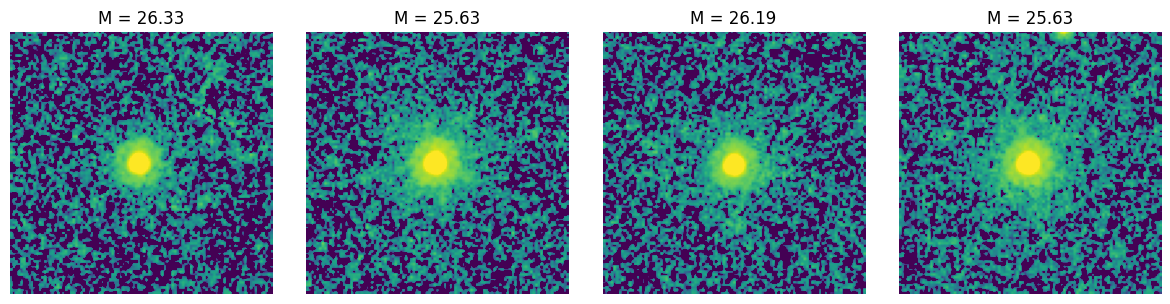

In [8]:
# generate input for STARRED
# make noise map
noise_maps = []
for i, star_img in enumerate(star_imgs):
    nx_im, ny_im = np.shape(star_img)
    noise_map_2 = np.abs(star_img) / star_whts[i] + sigma_bkd**2
    noise_maps.append(np.sqrt(noise_map_2))

# plot star cutouts
num_stars = len(mask.nonzero()[0])
ncols = 4 
nrows = (num_stars + ncols - 1) // ncols  # calculate number of rows needed

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
ax = ax.flatten()  # flatten the axes array for easy indexing

for i in range(num_stars):
    # display cutout image
    norm = ImageNormalize(np.arccosh(star_imgs[i]), vmin=-0.2, vmax=25, stretch=LogStretch())
    ax[i].imshow(star_imgs[i] / noise_maps[i], norm=norm, cmap='viridis', origin='lower')
    # ax[i].imshow(noise_maps[i], cmap='viridis', origin='lower', norm=norm)
    ax[i].set_title('M = {:.2f}' .format(cat_table[mask][i]['MAG_BEST'])) 
    ax[i].axis('off') 

# hide any remaining unused subplots
for j in range(num_stars, nrows * ncols):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

### setup working directory

In [9]:
test_dir = './psf_estimate/{}/{}' .format(filter, object_name)

if not os.path.isdir(test_dir):
    os.makedirs(test_dir)

star_dir = os.path.join(test_dir, 'stars')
noise_dir = os.path.join(test_dir, 'noise_maps')

if not os.path.isdir(star_dir):
    os.makedirs(star_dir)
if not os.path.isdir(noise_dir):
    os.makedirs(noise_dir) 

In [10]:
save_star_cutout = False

if save_star_cutout:

    if os.path.isdir(star_dir):
        file_temp = glob.glob(os.path.join(star_dir, 'star*.fits')) # if star cutout fits files exist, first remove them 
        for file in file_temp:
            os.remove(file)
    else:
        os.makedirs(star_dir)

    if os.path.isdir(noise_dir):
        file_temp = glob.glob(os.path.join(noise_dir, 'noise_map_*.fits')) # if noise map cutout fits files exist, first remove them 
        for file in file_temp:
            os.remove(file)
    else:
        os.makedirs(noise_dir) 
    
    for i in range(len(star_imgs)):
        hdu = fits.PrimaryHDU(star_imgs[i])
        hdul = fits.HDUList([hdu])
        hdul.writeto(os.path.join(star_dir, 'star_%i.fits'%(i)), overwrite=True)

        hdu = fits.PrimaryHDU(noise_maps[i])
        hdul = fits.HDUList([hdu])
        hdul.writeto(os.path.join(noise_dir, 'noise_map_%i.fits'%(i)), overwrite=True)

### STARRED PSF reconstruction

From the starred example notebook.

In [11]:
data_dim = star_imgs[0].shape[0]
masks = np.ones((len(star_imgs), data_dim, data_dim))
for i in range(len(star_imgs)):
    possiblemaskfilepath = os.path.join(noise_dir, 'mask_%s.reg'%str(i))
    if os.path.exists(possiblemaskfilepath):
        print('Using mask %s for star %i !'%(possiblemaskfilepath, i))
        r = pyregion.open(possiblemaskfilepath)
        masks[i, :, :] =  1 - r.get_mask(shape=(data_dim, data_dim)).astype(float)

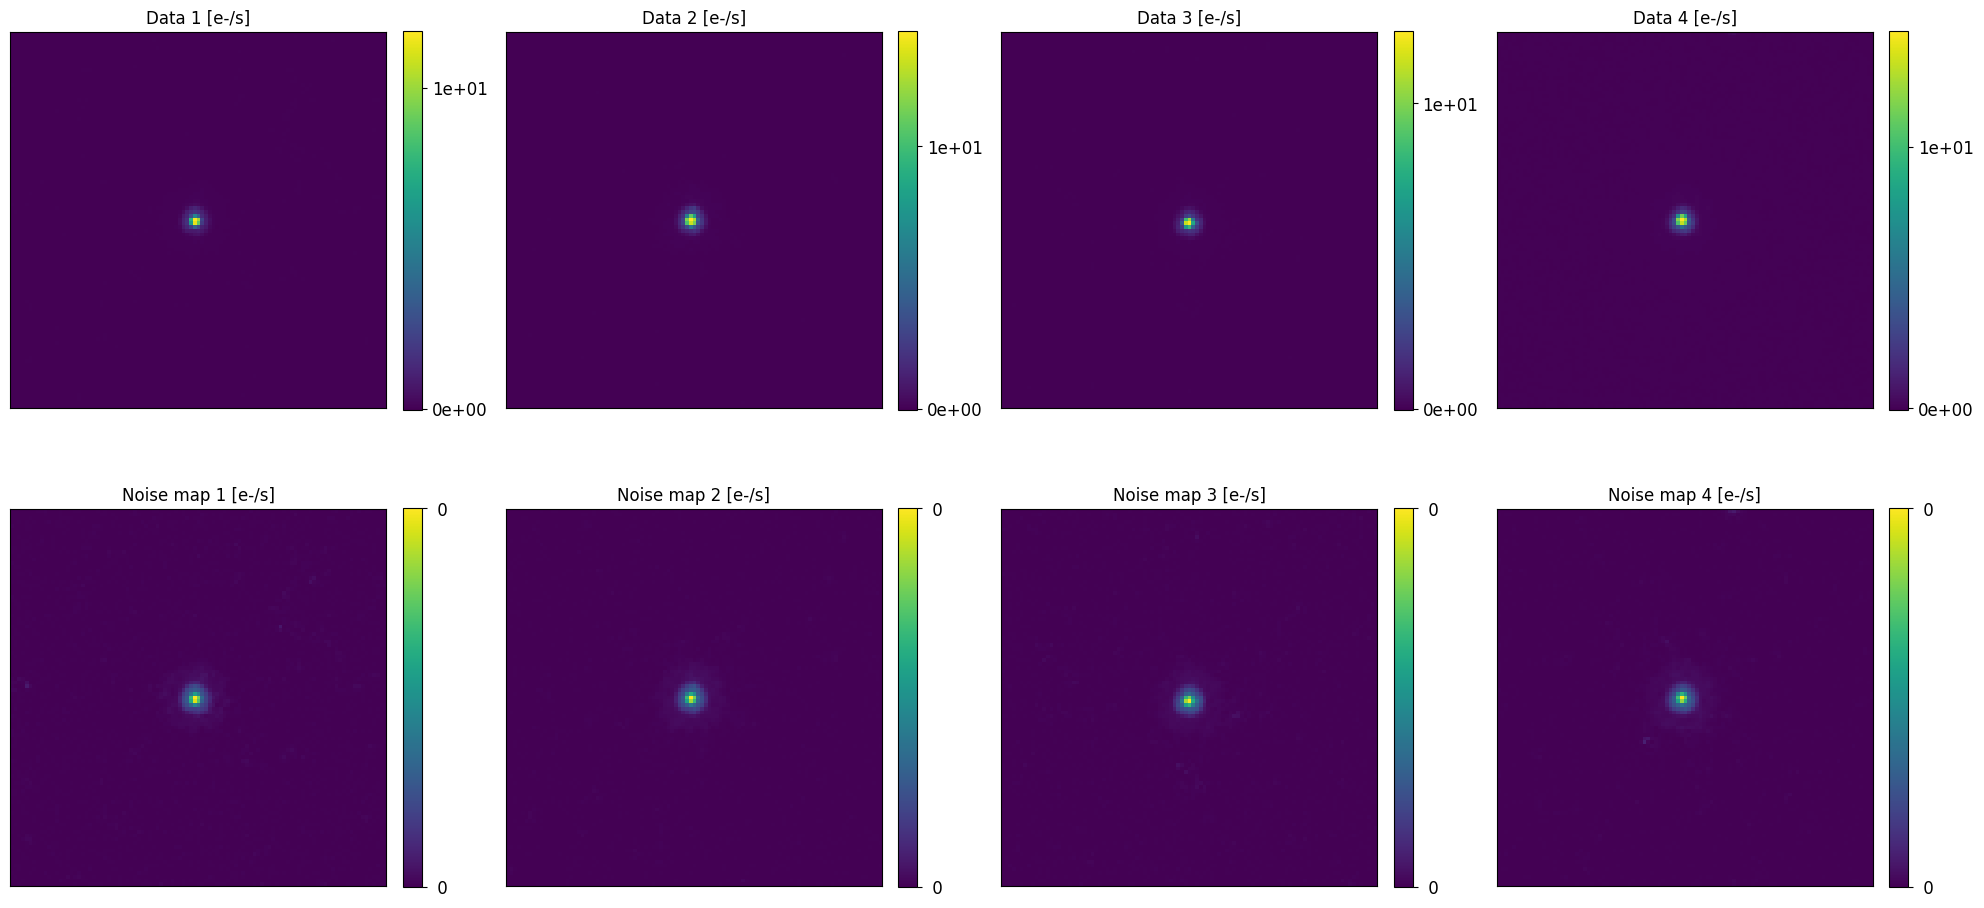

In [12]:
star_imgs_array = np.array(star_imgs)
noise_maps_array = np.array(noise_maps)

fig = pltf.display_data(star_imgs_array, sigma_2=noise_maps_array**2, masks=None, units='e-/s')

In [13]:
rerun_starred = False

if rerun_starred:

    lambda_scale = 2.
    lambda_hf = 2.
    niter = 1000
    subsampling = 3
    learning_rate = 1e-2
    noise_method = 'MC'

    file_to_run = '/home/xhuang/doubles_hst/starred/scripts/1_generate_psf.py'

    outputpath = os.path.abspath(os.path.join(test_dir, 'output_starred_psf'))

    if not os.path.isdir(outputpath):
        os.makedirs(outputpath)

    argument = '--data-path %s --output-path %s '%(star_dir,outputpath)
    argument += '--lambda-scales %2.2e '%lambda_scale
    argument += '--lambda-hf %2.2e '%lambda_hf
    argument += '--niter %i '%niter
    argument += '--subsampling-factor %i '%subsampling
    argument += '--noise-map-path %s '%noise_dir
    argument += '--method-noise %s '%noise_method
    argument += '--float64 '
    argument += '--init-learning-rate %2.2e '%learning_rate
    argument += '--optim-analytical Newton-CG '


    start_time = time.time()
    cmd = 'python3 %s %s'%(file_to_run, argument)
    print(cmd)
    os.system('python3 %s %s'%(file_to_run, argument))
    print('Running in %2.2f seconds'%(time.time() - start_time))

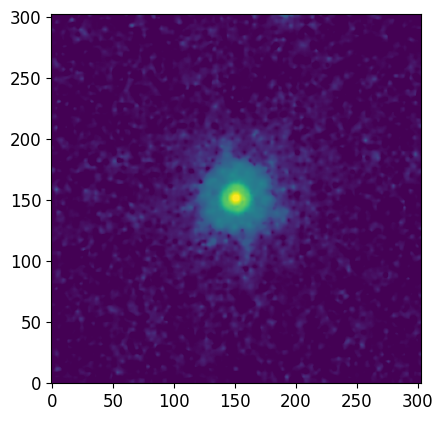

In [14]:
outputpath = os.path.abspath(os.path.join(test_dir, 'output_starred_psf'))
PSF_retrieved = fits.open(outputpath+ '/full_PSF.fits')[0].data
plt.imshow(PSF_retrieved, norm=colors.SymLogNorm(linthresh=0.00001, vmin=0, vmax=0.01), origin='lower')